# MERFISH mouse liver

In this notebook, we will use ovrlpy to investigate the [Vizgen MERFISH's mouse liver dataset](https://info.vizgen.com/mouse-liver-data).

We want to create a signal embedding of the transcriptome, and a vertical signal incoherence map to identify locations with a high risk of containing spatial doublets.

## Settings and Imports

First, let's define settings and input files.

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt

import ovrlpy

In [2]:
sample_nr = 1
slice_nr = 1

data_path = Path("/dh-projects/ag-ishaque/raw_data/vizgen-merfish/vz-liver-showcase")

coordinate_file = (
    data_path / f"Liver{sample_nr}Slice{slice_nr}" / "detected_transcripts.csv"
)

## Loading the data

Next, we want to load the data.

In [3]:
coordinate_df = ovrlpy.io.read_MERFISH(coordinate_file)

print(f"Number of transcripts: {len(coordinate_df):,}")

Number of transcripts: 417,243,171


In [4]:
coordinate_df.head()

x          y    z  gene
0  2506.4070 -95.451480  0.0  Comt
1  2531.8447 -95.187020  0.0  Comt
2  2483.7969 -91.360115  0.0  Comt
3  2505.7693 -84.081650  0.0  Comt
4  2501.3940 -81.387090  0.0  Comt

The dataset is quite large, so we will subset to a smaller region.

In [5]:
# subset to region
x_lims = (2000, 9000)
y_lims = (1000, 9000)

coordinate_df = coordinate_df.loc[
    lambda df: (df["x"] > x_lims[0])
    & (df["x"] < x_lims[1])
    & (df["y"] > y_lims[0])
    & (df["y"] < y_lims[1])
]

coordinate_df = coordinate_df.assign(
    x=lambda df: df["x"] - df["x"].min(), y=lambda df: df["y"] - df["y"].min()
)

print(f"Number of transcripts: {len(coordinate_df):,}")

Number of transcripts: 300,693,961


### Tissue overview 

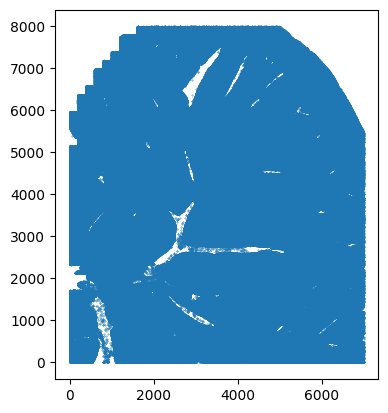

In [6]:
plt.scatter(coordinate_df.loc[::100, "x"], coordinate_df.loc[::100, "y"], s=0.1)
_ = plt.gca().set_aspect("equal", adjustable="box")

## Compute & Visualize coherence map

In [7]:
integrity, signal, visualizer = ovrlpy.run(
    df=coordinate_df, cell_diameter=7, n_expected_celltypes=10, n_workers=8
)

Running vertical adjustment
Creating gene expression embeddings for visualization:
Analyzing in 3d mode:
determining pseudocells:
found 137299 pseudocells
sampling expression:


100%|██████████| 120/120 [08:21<00:00,  4.18s/it]


Modeling 10 pseudo-celltype clusters;
Creating signal integrity map:


  0%|          | 1/224 [00:03<14:37,  3.94s/it]/dh-projects/ag-ishaque/analysis/muellni/envs/ovrlpy/lib/python3.12/site-packages/ovrlpy/_utils.py:397: RuntimeWarning: invalid value encountered in divide
  spatial_patch_cosine_similarity[patch_signal_mask] = np.sum(
  7%|▋         | 16/224 [00:55<09:28,  2.73s/it]/dh-projects/ag-ishaque/analysis/muellni/envs/ovrlpy/lib/python3.12/site-packages/ovrlpy/_utils.py:397: RuntimeWarning: invalid value encountered in divide
  spatial_patch_cosine_similarity[patch_signal_mask] = np.sum(
  8%|▊         | 17/224 [00:58<09:41,  2.81s/it]/dh-projects/ag-ishaque/analysis/muellni/envs/ovrlpy/lib/python3.12/site-packages/ovrlpy/_utils.py:397: RuntimeWarning: invalid value encountered in divide
  spatial_patch_cosine_similarity[patch_signal_mask] = np.sum(
  8%|▊         | 18/224 [01:01<09:52,  2.88s/it]/dh-projects/ag-ishaque/analysis/muellni/envs/ovrlpy/lib/python3.12/site-packages/ovrlpy/_utils.py:397: RuntimeWarning: invalid value encountered in div

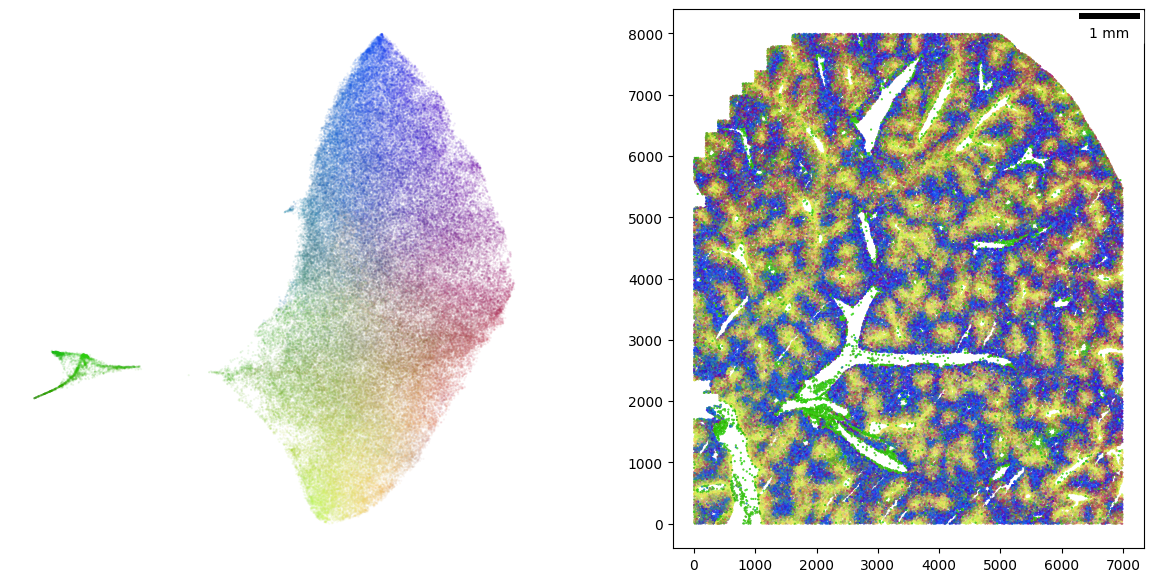

In [8]:
visualizer.plot_fit()

##  Signal integrity of the tissue sample 

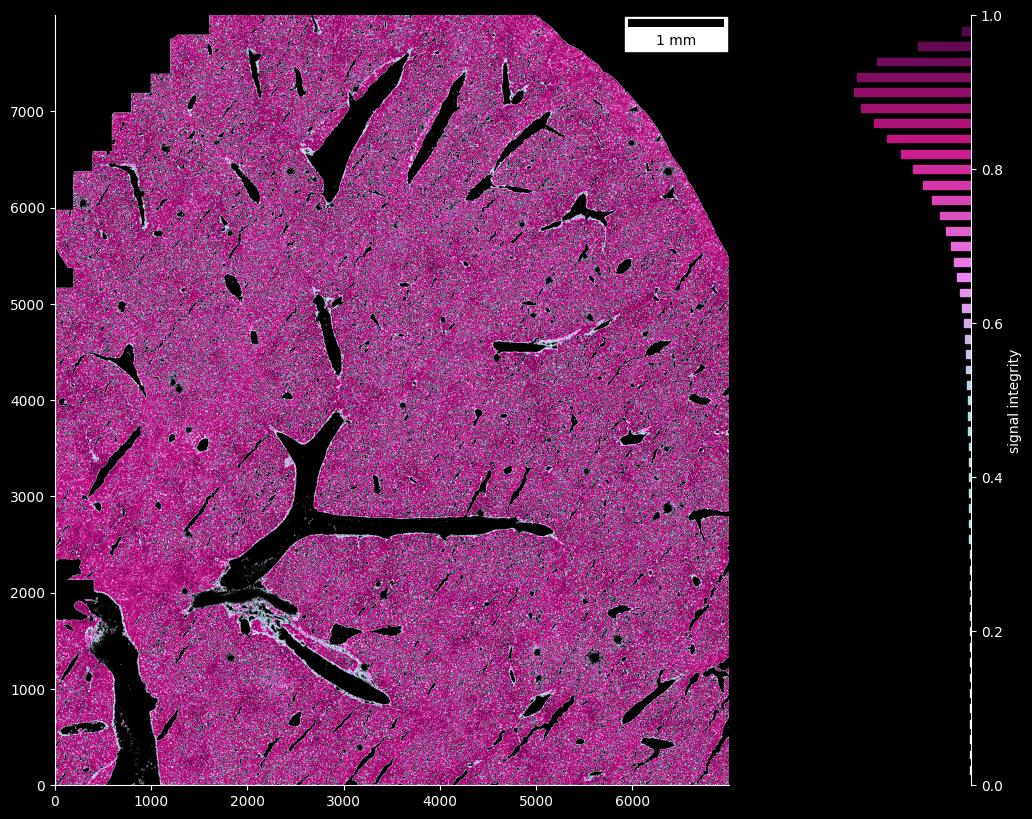

In [9]:
fig, ax = ovrlpy.plot_signal_integrity(integrity, signal, signal_threshold=3)

## Doublet probability 

In [18]:
doublet_df = ovrlpy.detect_doublets(
    integrity, signal, minimum_signal_strength=3, integrity_sigma=3
)

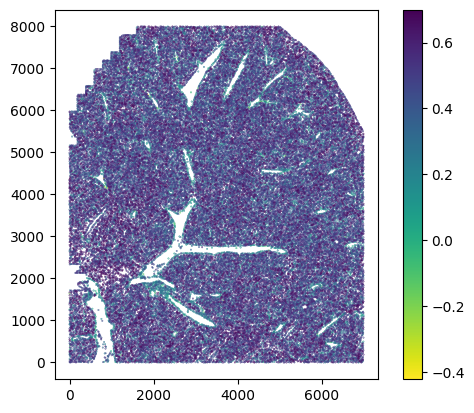

In [19]:
ax = plt.scatter(
    doublet_df["x"], doublet_df["y"], c=doublet_df["integrity"], s=0.1, cmap="viridis_r"
)
plt.gca().set_aspect("equal", adjustable="box")
_ = plt.colorbar(ax)

Visualize a specific doublet event like so.

/dh-projects/ag-ishaque/analysis/muellni/envs/ovrlpy/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


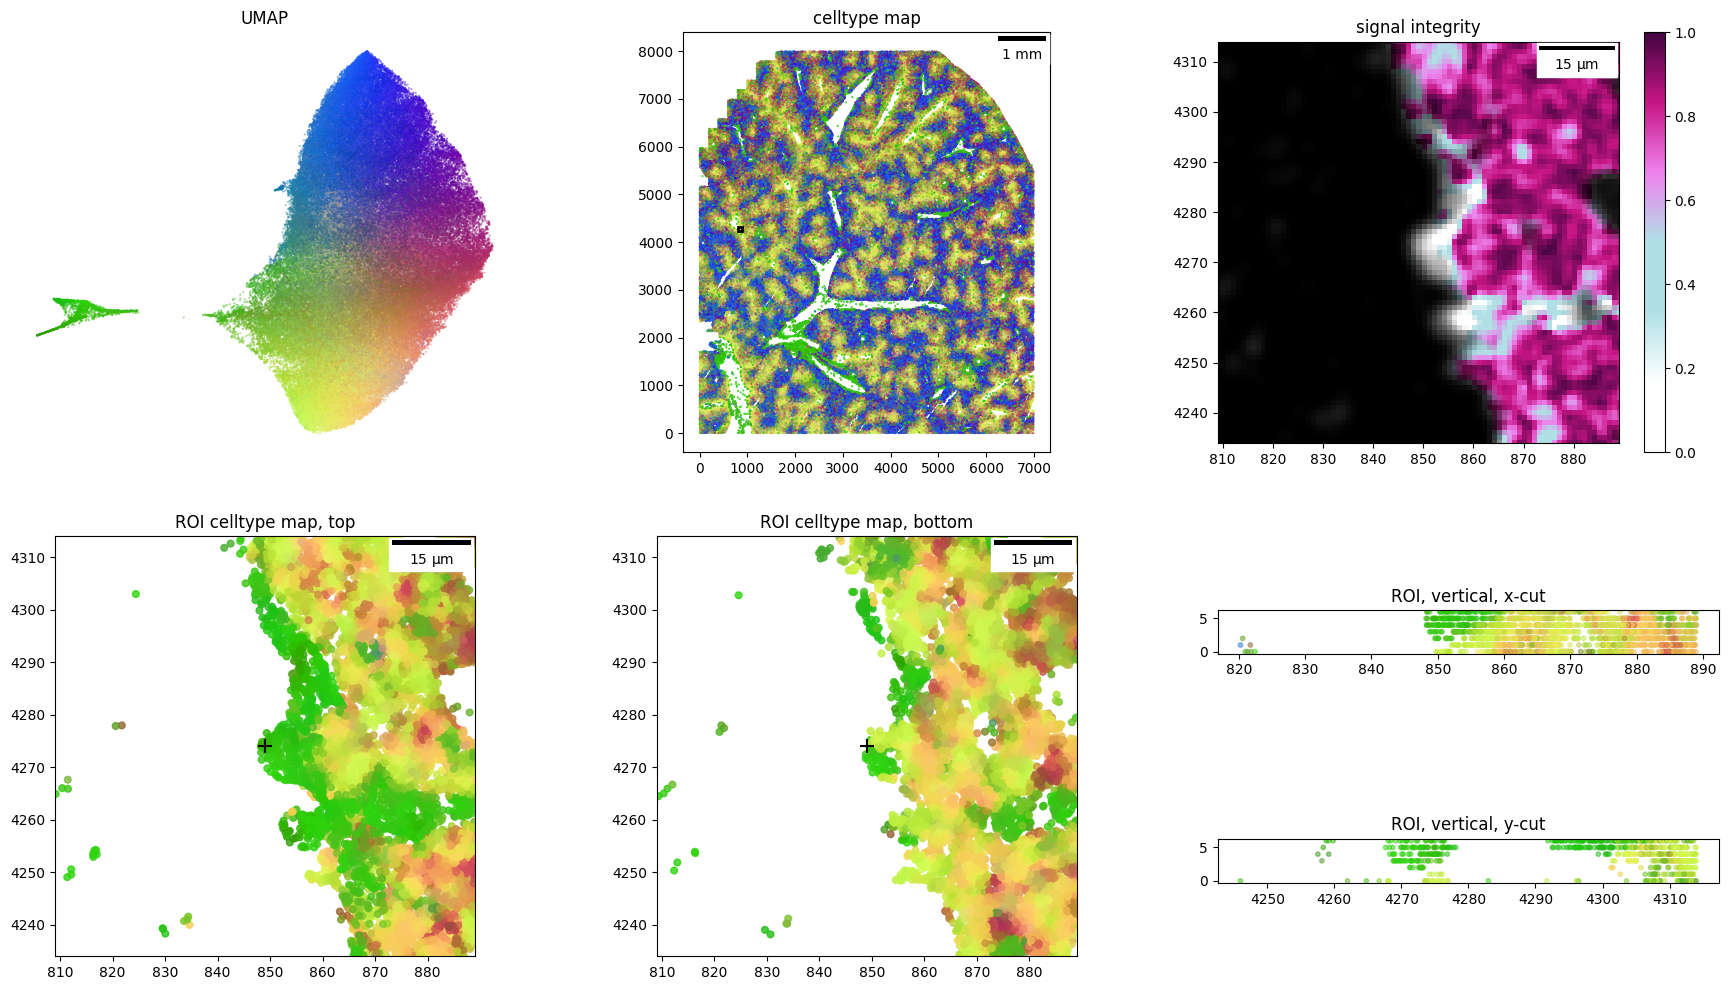

In [21]:
doublet_case = 100

x, y = doublet_df.loc[doublet_case, ["x", "y"]]

_ = ovrlpy.plot_region_of_interest(
    x, y, coordinate_df, visualizer, integrity, signal, window_size=40
)